# Efficient subset using Sentence Transformers

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import random
import os
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AutoModel, BertForSequenceClassification, BertModel
from transformers import AutoTokenizer, BertTokenizer
from transformers import AutoConfig

from torch.optim.lr_scheduler import StepLR
from transformers import get_linear_schedule_with_warmup


from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device.type)

SEED = 97
seed_everything(SEED)

Device:  cuda


In [3]:
data_train_df = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='ISO-8859-1')
data_test_df = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv')
len(data_train_df), len(data_test_df)

(41157, 3798)

In [4]:
data_train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
data_train_df.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

<Axes: xlabel='Sentiment', ylabel='count'>

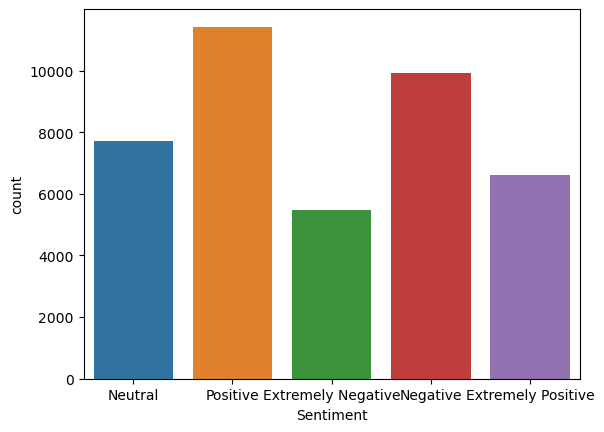

In [6]:
sns.countplot(data=data_train_df, x='Sentiment')

<Axes: xlabel='Sentiment', ylabel='count'>

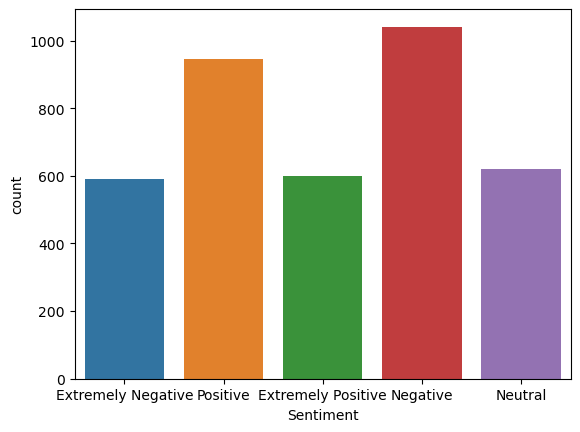

In [7]:
sns.countplot(data=data_test_df, x='Sentiment')

In [8]:
def combine_labels(label):
    if 'Positive' in label:
        return 'Positive'
    elif 'Negative' in label:
        return 'Negative'
    else:
        return label

In [9]:
data_train_df['Label'] = data_train_df['Sentiment'].apply(lambda x: combine_labels(x))
data_test_df['Label'] = data_test_df['Sentiment'].apply(lambda x: combine_labels(x))

In [10]:
data_train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Negative


In [11]:
data_test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Label
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,Neutral


Only working on positive/negative labels for experimentation purpose on binary classifcation

In [12]:
df = data_train_df[data_train_df['Label'] != 'Neutral'][['OriginalTweet', 'Label']]
test_df = data_test_df[data_test_df['Label'] != 'Neutral'][['OriginalTweet', 'Label']]
labels = {'Positive':0, 'Negative':1}
df['Label'] = df.Label.apply(lambda x: labels[x])
test_df['Label'] = test_df.Label.apply(lambda x: labels[x])

In [13]:
df.head()

,OriginalTweet,Label
1,advice Talk to your neighbours family to excha...,0
2,Coronavirus Australia: Woolworths to give elde...,0
3,My food stock is not the only one which is emp...,0
4,"Me, ready to go at supermarket during the #COV...",1
5,As news of the regionÂs first confirmed COVID...,0


In [14]:
test_df.head()

,OriginalTweet,Label
0,TRENDING: New Yorkers encounter empty supermar...,1
1,When I couldn't find hand sanitizer at Fred Me...,0
2,Find out how you can protect yourself and love...,0
3,#Panic buying hits #NewYork City as anxious sh...,1
6,Voting in the age of #coronavirus = hand sanit...,0


In [15]:
len(df), len(test_df)

(33444, 3179)

In [16]:
cfg = {}
BERT = 'bert-base-uncased'
DISTIL_BERT = 'distilbert-base-uncased'
ROBERTA = 'roberta-base'
MODEL_PATH = DISTIL_BERT

In [17]:
X_train, X_val, y_train, y_val = train_test_split(df.OriginalTweet, df.Label, test_size=0.15, random_state=SEED, stratify=df.Label)

In [18]:
len(X_train), len(X_val)

(28427, 5017)

In [49]:
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val_df = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

<Axes: xlabel='Label', ylabel='count'>

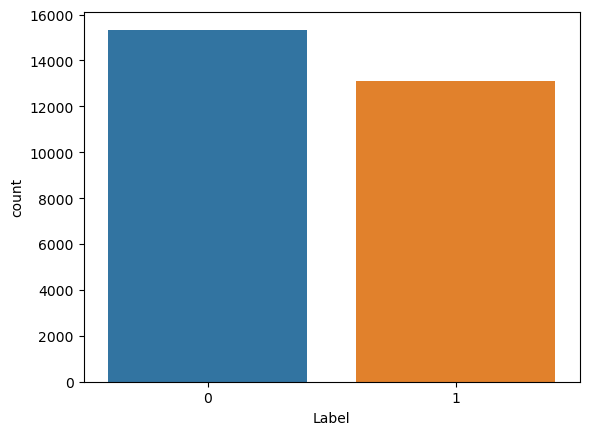

In [50]:
sns.countplot(data=train_df, x='Label')

<Axes: xlabel='Label', ylabel='count'>

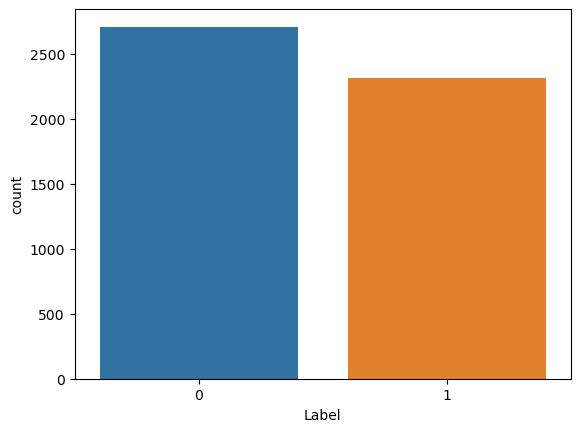

In [51]:
sns.countplot(data=val_df, x='Label')

In [52]:
cfg['tokenizer'] ={'name': MODEL_PATH, 'max_length': 256}
tokenizer = AutoTokenizer.from_pretrained(cfg['tokenizer']['name'])

In [53]:
cfg['train_batch_size'] = 32
cfg['valid_batch_size'] = 16
cfg['max_length'] = 256
cfg['epochs'] = 3
cfg['learning_rate'] = 1e-05

In [54]:
class TweetDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.len = len(df)
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        comment = self.df.loc[index, 'OriginalTweet']
        inputs = self.tokenizer.encode_plus(
            comment,                                 
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_len,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        
        if cfg['tokenizer']['name']=='bert-base-uncased':
            token_type_ids = inputs['token_type_ids'] 
        else:
            token_type_ids = 1.
        
        target = self.df.loc[index, 'Label']
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'masks': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(target, dtype=torch.long)
        }
    
    def __len__(self):
        return self.len

In [55]:
class TweetSentimentBERT(torch.nn.Module):
    def __init__(self, model_name, dropout=True):
        super(TweetSentimentBERT, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.model_name = model_name
        
        if model_name == BERT:
            self.in_features = self.bert.pooler.dense.out_features
        elif model_name == DISTIL_BERT:
            self.in_features = self.bert.transformer.layer[5].output_layer_norm.normalized_shape[0]
        elif model_name == ROBERTA:
            self.in_features = self.bert.pooler.dense.out_features
        else:
            self.in_features = 768
            
        self.dense = nn.Linear(self.in_features, self.in_features)
        self.activation = nn.ReLU()
        self.layer_norm = nn.LayerNorm(self.in_features)
        # self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, len(labels))

    def forward(self, input_ids, attention_mask, token_type_ids):    
        if self.model_name == BERT:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  token_type_ids=token_type_ids,
                                                  return_dict=False)
        elif self.model_name == DISTIL_BERT:
            last_hidden_state = self.bert(input_ids,
                                          attention_mask=attention_mask,
                                          return_dict=False)
            first_token_tensor = last_hidden_state[0][:, 0]
            output = self.dense(first_token_tensor)
            output = self.activation(output)
            
        elif self.model_name == ROBERTA:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  return_dict=False)
        
        output = self.layer_norm(output)
        # output = self.dropout(output)
        output = self.classifier(output)
        return output

In [56]:
def calc_accuracy(preds, targets):
    accuracy = (preds==targets).cpu().numpy().mean() * 100
    return accuracy

In [57]:
def train(model, loss_fn, train_dataloader, val_dataloader=None, epochs=3, evaluation=False):
    
    print("Start training...\n")
    for epoch in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0
        train_loss = []
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            model.zero_grad()
            input_ids = batch['ids'].to(device, dtype = torch.long)
            attention_mask = batch['masks'].to(device, dtype = torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            outputs = model(input_ids, attention_mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            train_loss.append(loss.item())
            
            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            if (step % 50 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        
        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, loss_fn, val_dataloader)
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
            print("-"*70)
        print("\n")
    
    print("Training complete!")

In [58]:
def evaluate(model, loss_fn, val_dataloader):
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        input_ids = batch['ids'].to(device, dtype = torch.long)
        attention_mask = batch['masks'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, token_type_ids)
        
        loss = loss_fn(outputs, targets)
        val_loss.append(loss.item())

        _, max_ids = torch.max(outputs.data, dim=1)
        val_accuracy.append(calc_accuracy(max_ids, targets))

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [59]:
train_data = TweetDataset(train_df, tokenizer, cfg['max_length'])
val_data = TweetDataset(val_df, tokenizer, cfg['max_length'])
test_data = TweetDataset(test_df, tokenizer, cfg['max_length'])

In [60]:
train_params = {'batch_size': cfg['train_batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

valid_params = {'batch_size': cfg['valid_batch_size'],
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': cfg['valid_batch_size'],
                'shuffle': False,
                'num_workers': 0
                }

train_loader = DataLoader(train_data, **train_params)
val_loader = DataLoader(val_data, **valid_params)
test_loader = DataLoader(test_data, **test_params)

In [32]:
model = TweetSentimentBERT(MODEL_PATH)
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TweetSentimentBERT(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Line

In [33]:
num_training_steps = cfg['epochs']*len(train_loader)
num_warmup_steps = 0
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=cfg['learning_rate'])
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

In [34]:
train(model, loss_function, train_loader, val_loader, epochs=cfg['epochs'], evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   50    |   0.660157   |     -      |     -     |   21.08  
   1    |   100   |   0.524165   |     -      |     -     |   19.09  
   1    |   150   |   0.474793   |     -      |     -     |   19.05  
   1    |   200   |   0.426537   |     -      |     -     |   19.12  
   1    |   250   |   0.396200   |     -      |     -     |   19.11  
   1    |   300   |   0.385780   |     -      |     -     |   19.21  
   1    |   350   |   0.402014   |     -      |     -     |   19.25  
   1    |   400   |   0.401437   |     -      |     -     |   19.26  
   1    |   450   |   0.363404   |     -      |     -     |   19.27  
   1    |   500   |   0.348922   |     -      |     -     |   19.15  
   1    |   550   |   0.325058   |     -      |     -     |   19.24  
   1    |   600   |   0.335551   |     -      |     -     |   19.28  


In [61]:
test_loss, test_accuracy = evaluate(model, loss_function, test_loader)
test_loss, test_accuracy

(0.2615058796162057, 90.23241206030151)

<Axes: xlabel='Label', ylabel='count'>

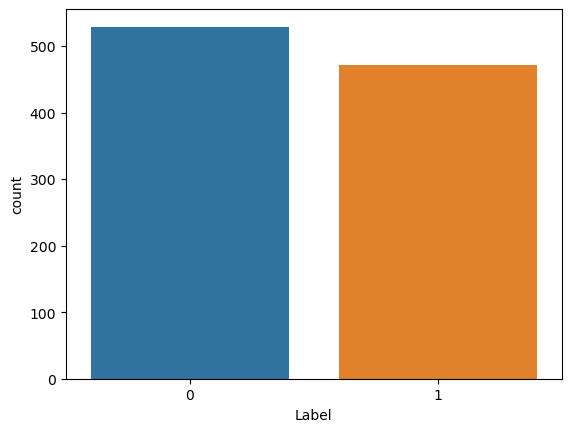

In [62]:
train_df_smpl = train_df.sample(1000).reset_index(drop=True)
sns.countplot(data=train_df_smpl, x='Label')

In [46]:
train_data_smpl = TweetDataset(train_df_smpl, tokenizer, cfg['max_length'])
train_loader_smpl = DataLoader(train_data_smpl, **train_params)

In [47]:
model_smpl = TweetSentimentBERT(MODEL_PATH)
model_smpl.to(device)
num_training_steps = cfg['epochs']*len(train_loader_smpl)
num_warmup_steps = 0
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model_smpl.parameters(), lr=cfg['learning_rate'])
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [48]:
train(model_smpl, loss_function, train_loader_smpl, val_loader, epochs=cfg['epochs'], evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   31    |   0.636724   |     -      |     -     |   11.93  
----------------------------------------------------------------------
   1    |    -    |   0.636724   |  0.563672  |   70.69   |   32.87  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   31    |   0.498695   |     -      |     -     |   11.93  
----------------------------------------------------------------------
   2    |    -    |   0.498695   |  0.519414  |   73.92   |   32.88  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-------------------------------------------------------------

In [63]:
test_loss, test_accuracy = evaluate(model_smpl, loss_function, test_loader)
test_loss, test_accuracy

(0.5495338335109117, 73.05561900411146)